# **Intrusion Detection System**

---



In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import glob
from sklearn.preprocessing import StandardScaler
import joblib
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


# **Data Collection**

---



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/network-intrusion-dataset


In [ ]:
root_path ="/kaggle/input/network-intrusion-dataset"

In [ ]:
csv_files = glob.glob('/kaggle/input/network-intrusion-dataset/*.csv')
data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

# **Data Preprocessing**

---



In [ ]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

In [ ]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,...,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06
mean,8.061534e+03,1.480065e+07,9.368972e+00,1.040396e+01,5.498522e+02,1.617903e+04,2.078044e+02,1.872929e+01,5.825628e+01,6.897811e+01,...,5.423519e+00,-2.744494e+03,8.163400e+04,4.117582e+04,1.533378e+05,5.835492e+04,8.324468e+06,5.043548e+05,8.704568e+06,7.928061e+06
std,1.827432e+04,3.366750e+07,7.500527e+02,9.978937e+02,9.998639e+03,2.264235e+06,7.175183e+02,6.035533e+01,1.861733e+02,2.813212e+02,...,6.367482e+02,1.085539e+06,6.489234e+05,3.935787e+05,1.026333e+06,5.773818e+05,2.364057e+07,4.605289e+06,2.437766e+07,2.337390e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,2.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.133800e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.239368e+06,5.000000e+00,4.000000e+00,1.880000e+02,4.840000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [ ]:
data.columns=data.columns.str.strip().str.lower().str.replace(' ', '_')

In [ ]:
data['label'].value_counts()

,count
label,
BENIGN,2271320
DoS Hulk,230124
PortScan,158804
DDoS,128025
DoS GoldenEye,10293
FTP-Patator,7935
SSH-Patator,5897
DoS slowloris,5796
DoS Slowhttptest,5499


In [ ]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(data.drop('label', axis=1))
y = data['label']
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
# Define classes to oversample (e.g., those with <10,000 instances)
rare_classes = ['Heartbleed', 'Infiltration', 'Web Attack � Sql Injection',
                'Web Attack � XSS', 'Web Attack � Brute Force', 'Bot',
                'DoS Slowhttptest', 'DoS slowloris', 'SSH-Patator', 'FTP-Patator',"DoS GoldenEye"]
rare_class_indices = [le.transform([cls])[0] for cls in rare_classes]

# Apply SMOTE to rare classes
smote = SMOTE(sampling_strategy={cls: 50000 for cls in rare_class_indices}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("New class distribution:", Counter(le.inverse_transform(y_balanced)))
class_weights = compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
class_weight_dict = dict(zip(np.unique(y_balanced), class_weights))

New class distribution: Counter({'BENIGN': 2271320, 'DoS Hulk': 230124, 'PortScan': 158804, 'DDoS': 128025, 'Web Attack � Brute Force': 50000, 'Web Attack � XSS': 50000, 'Web Attack � Sql Injection': 50000, 'FTP-Patator': 50000, 'SSH-Patator': 50000, 'Bot': 50000, 'Infiltration': 50000, 'DoS slowloris': 50000, 'DoS Slowhttptest': 50000, 'DoS GoldenEye': 50000, 'Heartbleed': 50000})


In [ ]:
y_balanced.value_counts()

,count
label,
0,2271320
4,230124
10,158804
2,128025
13,50000
14,50000
12,50000
11,50000
7,50000


# **Feature Selection**

---



In [ ]:
model = RandomForestClassifier(n_estimators=50, random_state=42,class_weight=class_weight_dict)
model.fit(X_balanced, y_balanced)
feature_importance = pd.Series(model.feature_importances_, index=data.drop('label', axis=1).columns).sort_values(ascending=False)
top_features = feature_importance.head(50).index
X_selected = X_balanced[:, [data.columns.get_loc(col) for col in top_features]]
print("Selected features:", top_features)
print(feature_importance)

Selected features: Index(['destination_port', 'init_win_bytes_backward', 'min_seg_size_forward',
       'total_length_of_bwd_packets', 'init_win_bytes_forward',
       'max_packet_length', 'fwd_packet_length_max', 'flow_iat_mean',
       'flow_iat_max', 'bwd_packets/s', 'flow_packets/s', 'fwd_iat_min',
       'avg_bwd_segment_size', 'total_length_of_fwd_packets', 'flow_iat_std',
       'average_packet_size', 'bwd_packet_length_min', 'fwd_iat_std',
       'bwd_packet_length_max', 'flow_bytes/s', 'subflow_bwd_bytes',
       'subflow_fwd_bytes', 'flow_duration', 'bwd_header_length',
       'packet_length_mean', 'fwd_iat_max', 'fwd_packets/s', 'fwd_iat_total',
       'bwd_packet_length_mean', 'fwd_header_length.1', 'fwd_iat_mean',
       'flow_iat_min', 'packet_length_std', 'packet_length_variance',
       'fwd_packet_length_std', 'avg_fwd_segment_size',
       'total_backward_packets', 'fwd_packet_length_mean',
       'subflow_fwd_packets', 'act_data_pkt_fwd', 'fwd_header_length',
       

In [ ]:
pd.DataFrame(X_selected)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.439936,-0.206432,0.002558,-0.004074,1.548624,0.012144,0.345908,-0.284851,-0.336869,-0.182538,...,0.001299,0.042172,-0.027368,0.033667,-0.101068,1.533791,-0.352126,-0.233678,-0.116471,-0.333439
1,-0.439936,-0.206432,0.002558,-0.004074,1.548624,0.012144,0.345908,-0.284711,-0.336573,-0.182574,...,0.001299,0.042172,-0.027368,0.033667,-0.101068,1.533791,-0.352126,-0.233408,-0.116471,-0.331848
2,-0.439936,-0.206432,0.002558,-0.007145,-0.467384,-0.468873,-0.289616,-0.288158,-0.375626,-0.019709,...,0.001237,-0.011158,-0.399578,-0.009424,-0.101068,-0.651979,-0.352126,-0.236804,-0.116471,-0.344489
3,-0.439936,-0.206432,0.002558,-0.004216,1.548624,0.012144,0.345908,-0.284669,-0.336542,-0.182604,...,0.001299,0.042172,-0.019694,0.031663,-0.101068,1.533791,-0.352126,-0.232990,-0.116471,-0.332424
4,1.495786,-0.200873,0.002558,-0.007145,-0.470662,-0.468873,-0.289616,-0.288185,-0.375630,0.497028,...,0.001237,-0.011158,-0.399578,-0.008422,-0.101068,-0.651979,-0.352126,-0.236804,-0.116465,-0.344487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338268,-0.436762,3.190206,0.002558,-0.007145,1.548624,-0.468873,-0.289616,0.126402,-0.146430,-0.183443,...,0.001240,-0.008491,-0.399578,-0.009424,-0.101068,1.533791,-0.352126,-0.236804,-0.116471,-0.344489
3338269,-0.436762,3.190206,0.002558,-0.007145,1.548624,-0.468873,-0.289616,0.087097,-0.168162,-0.183443,...,0.001240,-0.008491,-0.399578,-0.009424,-0.101068,1.533791,-0.352126,-0.236804,-0.116471,-0.344489
3338270,-0.436762,3.190206,0.002558,-0.007145,1.548624,-0.468873,-0.289616,0.116032,-0.152155,-0.183443,...,0.001240,-0.008491,-0.399578,-0.009424,-0.101068,1.533791,-0.352126,-0.236804,-0.116471,-0.344489
3338271,-0.436762,3.190206,0.002558,-0.007145,1.548624,-0.468873,-0.289616,0.125251,-0.147066,-0.183443,...,0.001240,-0.008491,-0.399578,-0.009424,-0.101068,1.533791,-0.352126,-0.236804,-0.116471,-0.344489


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_balanced, test_size=0.3, random_state=42)

# **Model Training**

---



In [36]:
model = XGBClassifier(n_estimators=100,
                      objective='multi:softmax',
                      num_class=len(np.unique(y_balanced)),
                      learning_rate=0.1,
                      max_depth=10,
                      random_state=42)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=15,
              num_parallel_tree=None, ...)

# **Evaluation**

---



                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    681552
                       Bot       0.98      1.00      0.99     15079
                      DDoS       1.00      1.00      1.00     38339
             DoS GoldenEye       1.00      1.00      1.00     14992
                  DoS Hulk       1.00      1.00      1.00     68883
          DoS Slowhttptest       1.00      1.00      1.00     15163
             DoS slowloris       1.00      1.00      1.00     14993
               FTP-Patator       1.00      1.00      1.00     14981
                Heartbleed       1.00      1.00      1.00     14941
              Infiltration       1.00      1.00      1.00     14870
                  PortScan       0.99      1.00      1.00     47877
               SSH-Patator       1.00      1.00      1.00     15022
  Web Attack � Brute Force       0.87      0.72      0.78     14831
Web Attack � Sql Injection       1.00      1.00

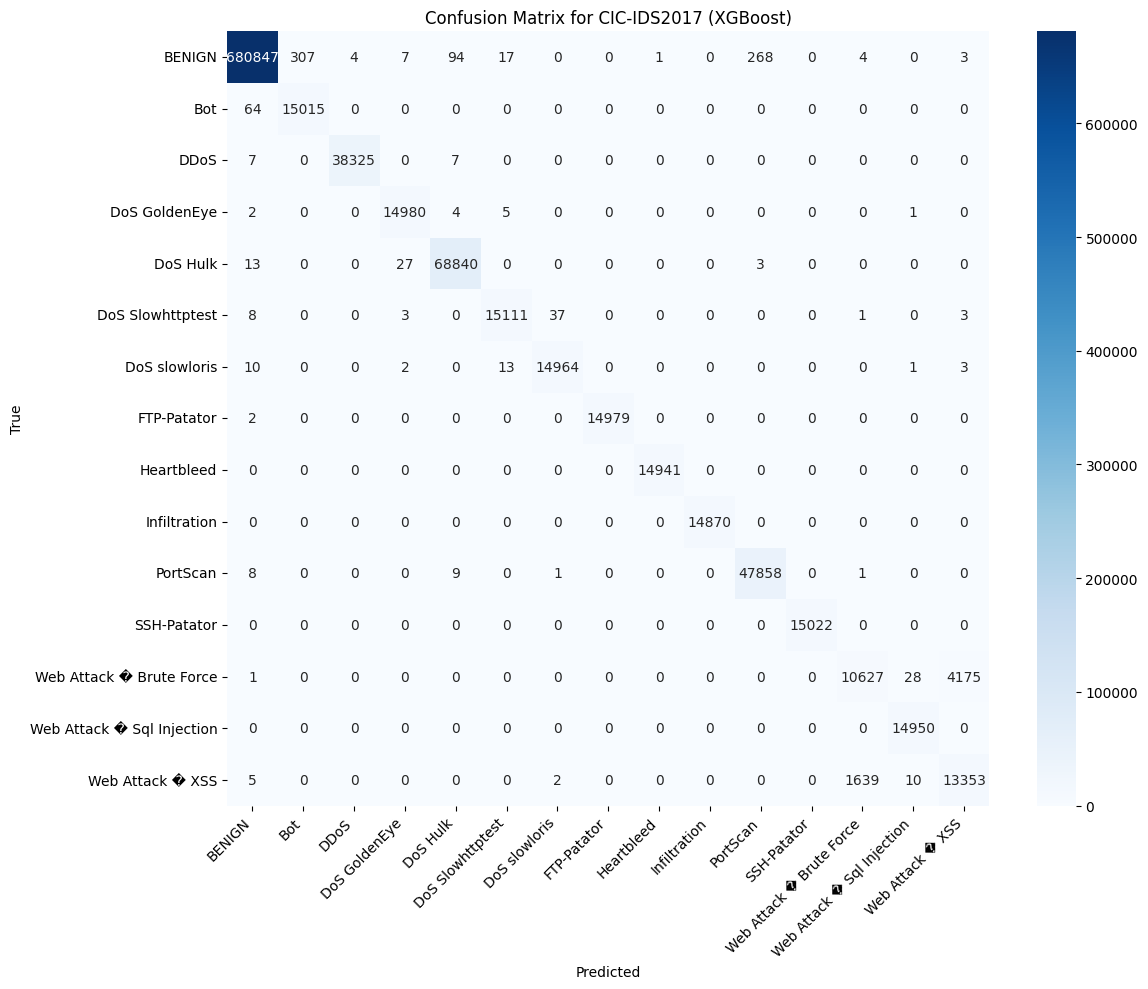

In [38]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


cm=confusion_matrix(y_test, y_pred)
labels = le.classes_
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIC-IDS2017 (XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [39]:
joblib.dump(model, 'xgb_model.pkl')

['xgb_model.pkl']